## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [4]:
import scanorama #Package required for batch correction

C:\Users\Lau Lab\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Mouse Data

In [2]:
train = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')
train3 = sc.read_h5ad('../data/3072-AS-1-GCCAAT_S1.h5ad')
#train4 = sc.read_h5ad('../data/3777-SM-2-CTTGTA_S2.h5ad')

test = sc.read_h5ad('../data/3777-SM-1-GCCAAT_S1.h5ad')
train = train.concatenate(train3)

In [3]:
%%time
# create new "observations" as percent and mean mito genes
train.var['mito'] = train.var_names.str.contains('mt-') # identify mitochondrial genes
train.obs['mean_mito'] = np.mean(train[:,train.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(train, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
test.var['mito'] = test.var_names.str.contains('mt-') # identify mitochondrial genes
test.obs['mean_mito'] = np.mean(test[:,test.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
train.obs['ranked_total_counts'] = np.argsort(train.obs['total_counts'])
test.obs['ranked_total_counts'] = np.argsort(test.obs['total_counts'])

Wall time: 1min 10s


In [5]:
adata = [test,train]
corrected = scanorama.correct_scanpy(adata)
integrate = scanorama.integrate_scanpy(corrected)
#Directly obtain the pca value using those function

Found 38459 genes among all datasets
[[0.         0.37837079]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 38459 genes among all datasets
[[0.         0.51488764]
 [0.         0.        ]]
Processing datasets (0, 1)


In [12]:
array1 = integrate[1]
array2 = integrate[0]
y=train.obs['ken_filter']

rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
lr = LogisticRegressionCV(cv=5, random_state=2, multi_class='multinomial', max_iter=1000)

lr.fit(array1, y)
prediction = lr.predict(array2)
test.obs['binary']=prediction

In [14]:
f_positive = 0
f_negative = 0
for i in range(0,len(test)):
    if test.obs['binary'][i]-test.obs['ken_filter'][i]>0:
        f_positive +=1
    if test.obs['binary'][i]-test.obs['ken_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_negative)/sum(test.obs['ken_filter']))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; correct N-label percent is %0.2f)' % total_acc)

miss-labeled as cell: 87 ; mislabeled as empty: 932 ; correct N-label percent is 0.59)


In [17]:
sc.pp.normalize_total(test, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test) # log1p transformation
sc.pp.scale(test, max_value=10) # scaling by variance and centering to zero for visualization

In [18]:
sc.tl.pca(test, n_comps=100)

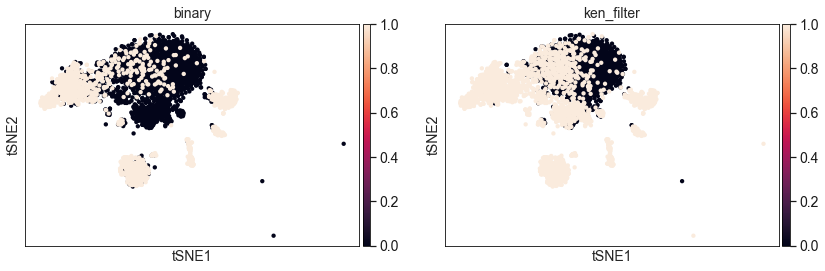

In [23]:
sc.tl.tsne(test, n_pcs=100,n_jobs=-1, perplexity=20, random_state=100) # perform tsne and plot results
sc.pl.tsne(test, color=['binary','ken_filter'], ncols=4, size=75)

In [22]:
%matplotlib inline #Run this line if plot not shown